In [134]:
from platform import python_version
import tensorflow as tf

print(tf.test.is_gpu_available())
print(python_version())

True
3.7.5


In [135]:
import os
import numpy as np
from os import listdir
from PIL import Image
import time
import tensorflow as tf
from tensorflow.keras import layers,models,optimizers
from keras import backend as K
import matplotlib.pyplot as plt

In [136]:
path="datasets/TSKinFace_Data/TSKinFace_cropped/"
randomiser = np.random.RandomState(123)

In [218]:
img_size = 64
mean = 0.
std_dev = 0.02
lr = 0.0005
b1 = 0.9
b2 = 0.99
sd_random_normal_init = 0.02

EPOCHS = 5
batch = 1

In [219]:
def generate_image(family_dir, family_number, gender):
    dic={}
    sub = ["F" , "M", gender]
    family_pth = path+"/"+family_dir+"/" + family_dir + "-" + str(family_number) + "-"
    for ele in sub:
        addr = family_pth+ele+".jpg"
        original_img = np.array(Image.open(addr))
        if ele =='F':
            dic['father'] = original_img
        elif ele == 'M':
            dic['mother'] = original_img
        elif ele == 'S':
            dic['child'] = original_img    
            dic['gender']=np.zeros((original_img.shape))
        elif ele == 'D':
            dic['child'] = original_img    
            dic['gender'] = np.ones((original_img.shape))
    return [dic['father'],dic['mother'],dic['gender'],dic['child']]

def generate_batch(families_batch):
    np_images=[]
    for family in families_batch:
        res = generate_image(family[0], family[1], family[2])
        if( res != None):
            np_images.append(res)
    return np_images

In [220]:
all_families = []
for i in range(285):
    all_families.append(['FMS', i+1, 'S'])
for i in range(274):
    all_families.append(['FMD', i+1, 'D'])
for i in range(228):
    all_families.append(['FMSD', i+1, 'D'])  
    all_families.append(['FMSD', i+1, 'S'])  
randomiser.shuffle(all_families)
train_families = all_families[:-100]
test_families = all_families[-100:]

In [221]:
OUTPUT_CHANNELS = 3

In [222]:
def gen_downsample_parent(filters, size, apply_batchnorm=True, apply_dropout=False):
    initializer = tf.random_normal_initializer(mean, std_dev) 
  

    result = tf.keras.Sequential()
    result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer,
                             use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
        
    result.add(tf.keras.layers.ELU())
        
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(rate = 0.5))

    return result

In [223]:
def gen_upsample(filters, size,apply_batchnorm = False):
    initializer = tf.random_normal_initializer(mean, std_dev)

    result = tf.keras.Sequential()
    result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                   use_bias=False))
    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
        result.add(tf.keras.layers.ELU())

    return result

In [224]:
def EncoderNN():
    down_stack_parent = [
    gen_downsample_parent(32,4,apply_batchnorm=True, apply_dropout=False),
    gen_downsample_parent(64,4,apply_batchnorm=True, apply_dropout=False)
    ]
    
#     down_stack_noise =[
# #   z = 4x4x64
#     gen_downsample_noise(64,4,apply_batchnorm=True), #8x8x64
#     gen_downsample_noise(32,4,apply_batchnorm=True) #16x16x32      
#     ]
    
    final_conv =[
        gen_upsample(32,4 ,apply_batchnorm = True)
    ]
    
    initializer = tf.random_normal_initializer(mean, sd_random_normal_init)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')

    concat = tf.keras.layers.Concatenate()

    father = tf.keras.layers.Input(shape=(img_size,img_size,3))
    mother = tf.keras.layers.Input(shape=(img_size,img_size,3))

    
    
    x1 = father
    for down in down_stack_parent:
        x1 = down(x1)
    
#     print(x1.shape)
    
    x2 = mother
    for down in down_stack_parent:
        x2 = down(x2) 
    
#     print(x2.shape)
    
    final = concat([x1,x2])
#     print(final.shape)
    final = final_conv[0](final)
    
    final = last(final)
#     print(final.shape)
    return tf.keras.Model(inputs=[father, mother], outputs=final)

In [225]:
encoder = EncoderNN()

In [226]:
encoder_optimizer = tf.keras.optimizers.Adam(learning_rate = lr, beta_1=b1)

In [227]:
def tensor_to_array(tensor1):
    return tensor1.numpy()

In [228]:
def train_encoder(father_batch, mother_batch, target_batch, b_size):
    with tf.GradientTape() as enc_tape:
        gen_outputs = encoder([father_batch, mother_batch], training=True)
        
        diff = tf.abs(target_batch - gen_outputs)
        flatten_diff = tf.reshape(diff, (b_size, img_size*img_size*3))
        
        encoder_loss_batch = tf.reduce_mean(flatten_diff, axis=1)
        encoder_loss = tf.reduce_mean(encoder_loss_batch)
    
    print("ENCODER_LOSS: ",tensor_to_array(encoder_loss))
    #calculate gradients
    encoder_gradients = enc_tape.gradient(encoder_loss,encoder.trainable_variables)

    #apply gradients on optimizer
    encoder_optimizer.apply_gradients(zip(encoder_gradients,encoder.trainable_variables))
    


In [229]:
def fit_encoder(train_ds, epochs, test_ds, batch):
    losses=np.array([])
    for epoch in range(epochs):
        print("______________________________EPOCH %d_______________________________"%(epoch+1))
        start = time.time()
        for i in range(len(train_ds)//batch):
            batch_data = np.asarray(generate_batch(train_ds[i*batch:(i+1)*batch]))
            batch_data = batch_data / 255 * 2 -1
            
            
            print("Generated batch", batch_data.shape)

            X_Father_train = tf.convert_to_tensor(batch_data[:,0],dtype =tf.float32)
            X_Mother_train = tf.convert_to_tensor(batch_data[:,1],dtype =tf.float32)
            Y_train = tf.convert_to_tensor(batch_data[:,3],dtype =tf.float32)
            
            train_encoder(X_Father_train, X_Mother_train, Y_train,batch)
            
            print("Trained for batch %d/%d"%(i+1,(len(train_ds)//batch)))
    print("______________________________TRAINING COMPLETED_______________________________")

In [230]:
train_dataset = all_families[:-100]
test_dataset = all_families[-100:]
encoder = EncoderNN()

with tf.device('/gpu:0'):
    fit_encoder(train_dataset, EPOCHS, test_dataset,batch)

______________________________EPOCH 1_______________________________
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.3631002
Trained for batch 1/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.36489427
Trained for batch 2/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.39414248
Trained for batch 3/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.3579793
Trained for batch 4/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.48212826
Trained for batch 5/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.2968116
Trained for batch 6/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.33758023
Trained for batch 7/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.40309098
Trained for batch 8/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.4225993
Trained for batch 9/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.4139906
Trained for batch 10/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.31958628
Trained for batch 11/915
Generated 

Trained for batch 102/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.23430516
Trained for batch 103/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.3502419
Trained for batch 104/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.36364016
Trained for batch 105/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.23494782
Trained for batch 106/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.3367153
Trained for batch 107/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.29591933
Trained for batch 108/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.3803229
Trained for batch 109/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.22483373
Trained for batch 110/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.29059398
Trained for batch 111/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.35812023
Trained for batch 112/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.3145245
Trained for batch 113/915
Generated batch (1, 4, 64, 64, 3

Trained for batch 199/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.33739412
Trained for batch 200/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.31849432
Trained for batch 201/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.25576803
Trained for batch 202/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.5380077
Trained for batch 203/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.2572588
Trained for batch 204/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.4222747
Trained for batch 205/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.24581213
Trained for batch 206/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.3110956
Trained for batch 207/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.56569076
Trained for batch 208/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.37711486
Trained for batch 209/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.35365638
Trained for batch 210/915
Generated batch (1, 4, 64, 64, 3

Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.2917545
Trained for batch 296/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.42733657
Trained for batch 297/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.28629646
Trained for batch 298/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.33204344
Trained for batch 299/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.24837403
Trained for batch 300/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.37437832
Trained for batch 301/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.50867367
Trained for batch 302/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.43007565
Trained for batch 303/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.3618745
Trained for batch 304/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.4994096
Trained for batch 305/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.3365729
Trained for batch 306/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.3314696

Trained for batch 397/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.28020376
Trained for batch 398/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.37154427
Trained for batch 399/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.4223062
Trained for batch 400/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.33433962
Trained for batch 401/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.24108164
Trained for batch 402/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.27523866
Trained for batch 403/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.3532441
Trained for batch 404/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.3912317
Trained for batch 405/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.25375894
Trained for batch 406/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.39662877
Trained for batch 407/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.38831377
Trained for batch 408/915
Generated batch (1, 4, 64, 64, 

Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.39329433
Trained for batch 498/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.31896356
Trained for batch 499/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.44132257
Trained for batch 500/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.2907115
Trained for batch 501/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.24754186
Trained for batch 502/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.35057393
Trained for batch 503/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.42808834
Trained for batch 504/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.508615
Trained for batch 505/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.30213207
Trained for batch 506/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.55122703
Trained for batch 507/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.34976473
Trained for batch 508/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.255839

Trained for batch 598/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.30230725
Trained for batch 599/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.4041122
Trained for batch 600/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.397557
Trained for batch 601/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.30164883
Trained for batch 602/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.2962424
Trained for batch 603/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.43158197
Trained for batch 604/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.3048352
Trained for batch 605/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.22930878
Trained for batch 606/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.26957437
Trained for batch 607/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.23549692
Trained for batch 608/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.24628758
Trained for batch 609/915
Generated batch (1, 4, 64, 64, 3)

Trained for batch 701/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.32966155
Trained for batch 702/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.32722506
Trained for batch 703/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.3149502
Trained for batch 704/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.2512163
Trained for batch 705/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.40192524
Trained for batch 706/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.38752317
Trained for batch 707/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.40360665
Trained for batch 708/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.3119211
Trained for batch 709/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.27850482
Trained for batch 710/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.41944125
Trained for batch 711/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.35486326
Trained for batch 712/915
Generated batch (1, 4, 64, 64, 

ENCODER_LOSS:  0.4086682
Trained for batch 798/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.34090388
Trained for batch 799/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.37697873
Trained for batch 800/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.33291212
Trained for batch 801/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.28757963
Trained for batch 802/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.32779205
Trained for batch 803/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.39372218
Trained for batch 804/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.42185113
Trained for batch 805/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.33452678
Trained for batch 806/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.30975905
Trained for batch 807/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.3105516
Trained for batch 808/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.37689066
Trained for batch 809/915
Gene

Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.31215096
Trained for batch 900/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.47935247
Trained for batch 901/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.42234507
Trained for batch 902/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.29981855
Trained for batch 903/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.3917172
Trained for batch 904/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.3306094
Trained for batch 905/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.35021877
Trained for batch 906/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.44226813
Trained for batch 907/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.2639039
Trained for batch 908/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.25811908
Trained for batch 909/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.28635094
Trained for batch 910/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.248946

ENCODER_LOSS:  0.36569476
Trained for batch 88/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.32424328
Trained for batch 89/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.42861006
Trained for batch 90/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.3135794
Trained for batch 91/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.31466725
Trained for batch 92/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.33218002
Trained for batch 93/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.2676408
Trained for batch 94/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.45659804
Trained for batch 95/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.45989642
Trained for batch 96/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.3071845
Trained for batch 97/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.4792414
Trained for batch 98/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.3070741
Trained for batch 99/915
Generated batch (1,

Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.3039582
Trained for batch 185/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.48052785
Trained for batch 186/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.24241452
Trained for batch 187/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.29939437
Trained for batch 188/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.24296665
Trained for batch 189/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.2894682
Trained for batch 190/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.35286856
Trained for batch 191/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.31694052
Trained for batch 192/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.37196591
Trained for batch 193/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.33707252
Trained for batch 194/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.25034824
Trained for batch 195/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.28521

Trained for batch 280/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.4050732
Trained for batch 281/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.36403832
Trained for batch 282/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.23110962
Trained for batch 283/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.267112
Trained for batch 284/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.263265
Trained for batch 285/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.41136336
Trained for batch 286/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.41707516
Trained for batch 287/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.42986083
Trained for batch 288/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.2803338
Trained for batch 289/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.46753073
Trained for batch 290/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.29458258
Trained for batch 291/915
Generated batch (1, 4, 64, 64, 3)


Trained for batch 376/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.36773166
Trained for batch 377/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.42897153
Trained for batch 378/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.39324093
Trained for batch 379/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.22820939
Trained for batch 380/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.33680272
Trained for batch 381/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.37420368
Trained for batch 382/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.36553904
Trained for batch 383/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.39718056
Trained for batch 384/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.33587328
Trained for batch 385/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.35498548
Trained for batch 386/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.39876652
Trained for batch 387/915
Generated batch (1, 4, 64, 6

Trained for batch 474/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.2762396
Trained for batch 475/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.31383434
Trained for batch 476/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.35588428
Trained for batch 477/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.36103174
Trained for batch 478/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.29475096
Trained for batch 479/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.31680053
Trained for batch 480/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.38595626
Trained for batch 481/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.2865691
Trained for batch 482/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.4155258
Trained for batch 483/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.4064544
Trained for batch 484/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.38112602
Trained for batch 485/915
Generated batch (1, 4, 64, 64, 3

Trained for batch 570/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.3253576
Trained for batch 571/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.35842356
Trained for batch 572/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.457278
Trained for batch 573/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.43540832
Trained for batch 574/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.39522305
Trained for batch 575/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.29543832
Trained for batch 576/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.47344065
Trained for batch 577/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.28054085
Trained for batch 578/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.21411066
Trained for batch 579/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.31400618
Trained for batch 580/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.36271262
Trained for batch 581/915
Generated batch (1, 4, 64, 64, 

Trained for batch 674/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.32656932
Trained for batch 675/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.2922768
Trained for batch 676/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.3273781
Trained for batch 677/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.28161344
Trained for batch 678/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.42423722
Trained for batch 679/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.32177648
Trained for batch 680/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.31980303
Trained for batch 681/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.3218799
Trained for batch 682/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.24394827
Trained for batch 683/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.249808
Trained for batch 684/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.19178872
Trained for batch 685/915
Generated batch (1, 4, 64, 64, 3)

Trained for batch 770/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.29538628
Trained for batch 771/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.28328362
Trained for batch 772/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.31620497
Trained for batch 773/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.27987382
Trained for batch 774/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.35408187
Trained for batch 775/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.43784094
Trained for batch 776/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.3291094
Trained for batch 777/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.35613194
Trained for batch 778/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.2462732
Trained for batch 779/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.41211697
Trained for batch 780/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.22260593
Trained for batch 781/915
Generated batch (1, 4, 64, 64,

Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.2895528
Trained for batch 868/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.34658757
Trained for batch 869/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.26958647
Trained for batch 870/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.32135043
Trained for batch 871/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.40899655
Trained for batch 872/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.19624631
Trained for batch 873/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.2201513
Trained for batch 874/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.4627359
Trained for batch 875/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.33875895
Trained for batch 876/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.41155437
Trained for batch 877/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.23658724
Trained for batch 878/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.374708

Trained for batch 48/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.46293196
Trained for batch 49/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.3132094
Trained for batch 50/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.35162807
Trained for batch 51/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.36841455
Trained for batch 52/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.28441808
Trained for batch 53/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.2514844
Trained for batch 54/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.2676935
Trained for batch 55/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.35915586
Trained for batch 56/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.42769685
Trained for batch 57/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.39227185
Trained for batch 58/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.31745198
Trained for batch 59/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_L

Trained for batch 153/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.2925547
Trained for batch 154/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.24780934
Trained for batch 155/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.31988356
Trained for batch 156/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.36583677
Trained for batch 157/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.5206266
Trained for batch 158/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.31948948
Trained for batch 159/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.31432286
Trained for batch 160/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.26781285
Trained for batch 161/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.24980456
Trained for batch 162/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.34398428
Trained for batch 163/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.45276225
Trained for batch 164/915
Generated batch (1, 4, 64, 64,

Trained for batch 257/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.50906175
Trained for batch 258/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.366709
Trained for batch 259/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.30277357
Trained for batch 260/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.28126484
Trained for batch 261/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.3887117
Trained for batch 262/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.40077356
Trained for batch 263/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.21528268
Trained for batch 264/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.22384524
Trained for batch 265/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.396935
Trained for batch 266/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.25999713
Trained for batch 267/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.40374827
Trained for batch 268/915
Generated batch (1, 4, 64, 64, 3)

Trained for batch 354/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.23245847
Trained for batch 355/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.31747076
Trained for batch 356/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.23558982
Trained for batch 357/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.3651441
Trained for batch 358/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.3351229
Trained for batch 359/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.40976223
Trained for batch 360/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.34908438
Trained for batch 361/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.3860208
Trained for batch 362/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.39548895
Trained for batch 363/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.3916135
Trained for batch 364/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.1996816
Trained for batch 365/915
Generated batch (1, 4, 64, 64, 3)

Trained for batch 451/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.3398424
Trained for batch 452/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.52897924
Trained for batch 453/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.38221368
Trained for batch 454/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.3969697
Trained for batch 455/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.34147444
Trained for batch 456/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.33019084
Trained for batch 457/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.39267787
Trained for batch 458/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.31211004
Trained for batch 459/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.30797324
Trained for batch 460/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.27457392
Trained for batch 461/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.30778563
Trained for batch 462/915
Generated batch (1, 4, 64, 64,

Trained for batch 549/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.27165398
Trained for batch 550/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.38959578
Trained for batch 551/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.5435202
Trained for batch 552/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.2367382
Trained for batch 553/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.31269932
Trained for batch 554/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.257978
Trained for batch 555/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.3732551
Trained for batch 556/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.3133055
Trained for batch 557/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.29079965
Trained for batch 558/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.29665217
Trained for batch 559/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.28285545
Trained for batch 560/915
Generated batch (1, 4, 64, 64, 3)


Trained for batch 646/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.27284268
Trained for batch 647/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.28507918
Trained for batch 648/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.19604743
Trained for batch 649/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.3348591
Trained for batch 650/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.43399644
Trained for batch 651/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.3619548
Trained for batch 652/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.32611695
Trained for batch 653/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.27351788
Trained for batch 654/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.3509954
Trained for batch 655/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.38534597
Trained for batch 656/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.477576
Trained for batch 657/915
Generated batch (1, 4, 64, 64, 3)

Trained for batch 750/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.36531663
Trained for batch 751/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.43623152
Trained for batch 752/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.28506592
Trained for batch 753/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.2518762
Trained for batch 754/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.4042904
Trained for batch 755/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.27988213
Trained for batch 756/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.44482073
Trained for batch 757/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.21197003
Trained for batch 758/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.2937575
Trained for batch 759/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.24270622
Trained for batch 760/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.36625776
Trained for batch 761/915
Generated batch (1, 4, 64, 64, 

Trained for batch 847/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.35365495
Trained for batch 848/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.3174886
Trained for batch 849/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.3084567
Trained for batch 850/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.34285212
Trained for batch 851/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.2607317
Trained for batch 852/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.38126525
Trained for batch 853/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.38295588
Trained for batch 854/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.292807
Trained for batch 855/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.25781342
Trained for batch 856/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.31267673
Trained for batch 857/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.41312864
Trained for batch 858/915
Generated batch (1, 4, 64, 64, 3)

ENCODER_LOSS:  0.27887717
Trained for batch 28/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.2532797
Trained for batch 29/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.2921671
Trained for batch 30/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.3783232
Trained for batch 31/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.35691848
Trained for batch 32/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.33799353
Trained for batch 33/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.38243708
Trained for batch 34/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.31943387
Trained for batch 35/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.29562014
Trained for batch 36/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.31755462
Trained for batch 37/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.22563529
Trained for batch 38/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.28854844
Trained for batch 39/915
Generated batch (

Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.2968545
Trained for batch 125/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.32047004
Trained for batch 126/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.26741526
Trained for batch 127/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.55552435
Trained for batch 128/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.29588625
Trained for batch 129/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.40410367
Trained for batch 130/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.39285132
Trained for batch 131/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.36687633
Trained for batch 132/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.29944
Trained for batch 133/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.38315547
Trained for batch 134/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.44609967
Trained for batch 135/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.3407439

ENCODER_LOSS:  0.19835745
Trained for batch 222/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.39470902
Trained for batch 223/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.3246741
Trained for batch 224/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.24437328
Trained for batch 225/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.23235746
Trained for batch 226/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.44603923
Trained for batch 227/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.34380975
Trained for batch 228/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.22963054
Trained for batch 229/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.35539496
Trained for batch 230/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.38545075
Trained for batch 231/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.2871401
Trained for batch 232/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.23406672
Trained for batch 233/915
Gene

Trained for batch 318/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.4114194
Trained for batch 319/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.32498375
Trained for batch 320/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.34228778
Trained for batch 321/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.36121055
Trained for batch 322/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.4056014
Trained for batch 323/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.26497543
Trained for batch 324/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.21808684
Trained for batch 325/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.4737893
Trained for batch 326/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.3380899
Trained for batch 327/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.24816656
Trained for batch 328/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.37993076
Trained for batch 329/915
Generated batch (1, 4, 64, 64, 3

Trained for batch 416/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.42532983
Trained for batch 417/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.29196814
Trained for batch 418/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.26624265
Trained for batch 419/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.21244222
Trained for batch 420/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.29073927
Trained for batch 421/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.23654218
Trained for batch 422/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.27207968
Trained for batch 423/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.30218098
Trained for batch 424/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.30781925
Trained for batch 425/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.36373332
Trained for batch 426/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.29077494
Trained for batch 427/915
Generated batch (1, 4, 64, 6

Trained for batch 514/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.31173706
Trained for batch 515/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.32500482
Trained for batch 516/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.25483322
Trained for batch 517/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.3326907
Trained for batch 518/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.32122517
Trained for batch 519/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.30709147
Trained for batch 520/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.2720342
Trained for batch 521/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.25104865
Trained for batch 522/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.47774446
Trained for batch 523/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.26467443
Trained for batch 524/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.3261071
Trained for batch 525/915
Generated batch (1, 4, 64, 64, 

Trained for batch 611/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.260686
Trained for batch 612/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.35631838
Trained for batch 613/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.22815712
Trained for batch 614/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.33474112
Trained for batch 615/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.1837279
Trained for batch 616/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.27650926
Trained for batch 617/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.3483181
Trained for batch 618/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.2321472
Trained for batch 619/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.30835256
Trained for batch 620/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.31099087
Trained for batch 621/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.34920835
Trained for batch 622/915
Generated batch (1, 4, 64, 64, 3)

Trained for batch 709/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.2713108
Trained for batch 710/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.42389727
Trained for batch 711/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.3538188
Trained for batch 712/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.3655393
Trained for batch 713/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.45167089
Trained for batch 714/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.32790706
Trained for batch 715/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.31689832
Trained for batch 716/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.36152196
Trained for batch 717/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.37449014
Trained for batch 718/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.39428344
Trained for batch 719/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.2719704
Trained for batch 720/915
Generated batch (1, 4, 64, 64, 3

Trained for batch 807/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.29955468
Trained for batch 808/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.38333905
Trained for batch 809/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.27831408
Trained for batch 810/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.26771557
Trained for batch 811/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.34705636
Trained for batch 812/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.38693652
Trained for batch 813/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.3197151
Trained for batch 814/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.43012595
Trained for batch 815/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.34915355
Trained for batch 816/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.27932402
Trained for batch 817/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.49306092
Trained for batch 818/915
Generated batch (1, 4, 64, 64

Trained for batch 904/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.31445673
Trained for batch 905/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.3232412
Trained for batch 906/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.44707242
Trained for batch 907/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.2657493
Trained for batch 908/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.24865115
Trained for batch 909/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.2540101
Trained for batch 910/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.23134893
Trained for batch 911/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.36583027
Trained for batch 912/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.33470777
Trained for batch 913/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.35467502
Trained for batch 914/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.41839263
Trained for batch 915/915
______________________________E

Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.2221061
Trained for batch 87/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.35238862
Trained for batch 88/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.31186992
Trained for batch 89/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.37869322
Trained for batch 90/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.3071194
Trained for batch 91/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.31114304
Trained for batch 92/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.32598343
Trained for batch 93/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.24738038
Trained for batch 94/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.43044266
Trained for batch 95/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.42176697
Trained for batch 96/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.28081203
Trained for batch 97/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.4575664
Trained 

Trained for batch 183/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.3746165
Trained for batch 184/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.27339232
Trained for batch 185/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.48809195
Trained for batch 186/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.25358468
Trained for batch 187/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.2821395
Trained for batch 188/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.24152188
Trained for batch 189/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.26159427
Trained for batch 190/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.31392303
Trained for batch 191/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.2883266
Trained for batch 192/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.35400578
Trained for batch 193/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.3442495
Trained for batch 194/915
Generated batch (1, 4, 64, 64, 3

Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.35562703
Trained for batch 282/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.22533298
Trained for batch 283/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.21185274
Trained for batch 284/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.24940722
Trained for batch 285/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.41405293
Trained for batch 286/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.41357878
Trained for batch 287/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.3928437
Trained for batch 288/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.26812384
Trained for batch 289/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.46325457
Trained for batch 290/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.28922474
Trained for batch 291/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.31838143
Trained for batch 292/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.2686

Trained for batch 380/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.35908806
Trained for batch 381/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.36767873
Trained for batch 382/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.31498882
Trained for batch 383/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.37666377
Trained for batch 384/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.33084622
Trained for batch 385/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.35835862
Trained for batch 386/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.35928497
Trained for batch 387/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.3395842
Trained for batch 388/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.31447586
Trained for batch 389/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.21047437
Trained for batch 390/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.22538942
Trained for batch 391/915
Generated batch (1, 4, 64, 64

Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.2707922
Trained for batch 479/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.31209666
Trained for batch 480/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.36668348
Trained for batch 481/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.30897596
Trained for batch 482/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.40972197
Trained for batch 483/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.40088436
Trained for batch 484/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.32530403
Trained for batch 485/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.2959082
Trained for batch 486/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.4225807
Trained for batch 487/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.27903357
Trained for batch 488/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.21667863
Trained for batch 489/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.381118

Trained for batch 575/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.305103
Trained for batch 576/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.49186754
Trained for batch 577/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.27892458
Trained for batch 578/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.2066168
Trained for batch 579/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.312698
Trained for batch 580/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.3354644
Trained for batch 581/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.28269127
Trained for batch 582/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.27629936
Trained for batch 583/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.4521097
Trained for batch 584/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.2747468
Trained for batch 585/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.32378557
Trained for batch 586/915
Generated batch (1, 4, 64, 64, 3)
EN

ENCODER_LOSS:  0.25379288
Trained for batch 673/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.35858956
Trained for batch 674/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.29549527
Trained for batch 675/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.28494942
Trained for batch 676/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.33453584
Trained for batch 677/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.29430747
Trained for batch 678/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.38504538
Trained for batch 679/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.28140268
Trained for batch 680/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.31766167
Trained for batch 681/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.31814328
Trained for batch 682/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.2613983
Trained for batch 683/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.21432412
Trained for batch 684/915
Gen

Trained for batch 771/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.2857602
Trained for batch 772/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.30883098
Trained for batch 773/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.26693907
Trained for batch 774/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.36015418
Trained for batch 775/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.41695955
Trained for batch 776/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.28641725
Trained for batch 777/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.35475573
Trained for batch 778/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.2626796
Trained for batch 779/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.37316456
Trained for batch 780/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.22067535
Trained for batch 781/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.28531262
Trained for batch 782/915
Generated batch (1, 4, 64, 64,

Trained for batch 869/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.2633415
Trained for batch 870/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.33153316
Trained for batch 871/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.40549588
Trained for batch 872/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.20763415
Trained for batch 873/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.21591079
Trained for batch 874/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.4506798
Trained for batch 875/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.28457057
Trained for batch 876/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.39604712
Trained for batch 877/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.22024189
Trained for batch 878/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.33458817
Trained for batch 879/915
Generated batch (1, 4, 64, 64, 3)
ENCODER_LOSS:  0.32003284
Trained for batch 880/915
Generated batch (1, 4, 64, 64,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-0.97180027
0.93123335


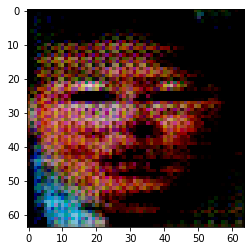

In [244]:
family_no = 50
family_data = generate_image(all_families[family_no][0], all_families[family_no][1], all_families[family_no][2])
inp = [family_data[0],family_data[1]]
inp = tf.cast(inp, tf.float32)
father_inp = inp[0][tf.newaxis,...]
mother_inp = inp[1][tf.newaxis,...]
with tf.device('/gpu:0'):
    gen_output = encoder([father_inp, mother_inp], training=True)
temp = gen_output.numpy()
plt.imshow(np.squeeze(temp))
# print(temp)
print(np.amin(temp))
print(np.amax(temp))

###############################################################################################################################

In [49]:
def disc_downsample_parent_target(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(mean, std_dev) 
  

    result = tf.keras.Sequential()
    result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer,
                             use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
        
    result.add(tf.keras.layers.LeakyReLU(alpha = 0.2))

    return result

In [50]:
def disc_loss(filters, size,apply_batchnorm = False):
    initializer = tf.random_normal_initializer(mean, std_dev)

    result = tf.keras.Sequential()
    result.add(
    tf.keras.layers.Conv2D(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                   use_bias=False))
    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
        
    result.add(tf.keras.layers.LeakyReLU(alpha = 0.2))
    
    return result

In [51]:
def Discriminator():

    father = tf.keras.layers.Input(shape=(img_size,img_size,3))
    mother = tf.keras.layers.Input(shape=(img_size,img_size,3))
    target = tf.keras.layers.Input(shape=(img_size,img_size,3))
    
    down_stack_parent_target = [
    disc_downsample_parent_target(32,4,apply_batchnorm=False), #32x32x32
    disc_downsample_parent_target(64,4,apply_batchnorm=True)   #16x16x64
    ]
    
    down_stack_combined =[
    disc_loss(192,4,apply_batchnorm=True),
    disc_loss(256,4,apply_batchnorm=False)
    ]
    
    initializer = tf.random_normal_initializer(mean, sd_random_normal_init)
    last = tf.keras.layers.Conv2D(1, 4, strides=1,padding='same',
                                  kernel_initializer=initializer) # linear layer
    
    
    concat = tf.keras.layers.Concatenate()
    x1 = father
    for down in down_stack_parent_target:
        x1 = down(x1)
    
    x2 = mother
    for down in down_stack_parent_target:
        x2 = down(x2)
        
    x3 = target
    for down in down_stack_parent_target:
        x3 = down(x3)
    
    combined = concat([x1,x2,x3])
    # combined is Batchx16x16x192
    
    x4 = combined
    for down in down_stack_combined:
        x4 = down(x4)
#     print(x4.shape)
    
    output = last(x4) #4X4 
#     print(output.shape)

    return tf.keras.Model(inputs=[father,mother,target], outputs=output)

In [52]:
discriminator = Discriminator()

In [53]:
# family_data = generate_image(all_families[126])
# p1 = tf.cast(family_data[0], tf.float32)
# p2 = tf.cast(family_data[1], tf.float32)
# c = tf.cast(family_data[2], tf.float32)

# discriminator = Discriminator()
# with tf.device('/cpu:0'):
#     disc_out = discriminator(inputs = [p1,p2,c], training=True)

In [97]:
LAMBDA = 100

In [98]:
def tensor_to_array(tensor1):
    return tensor1.numpy()

In [99]:
def discriminator_loss(disc_real_output, disc_generated_output,b_size):
    real_loss_diff = tf.abs(tf.ones_like(disc_real_output) - disc_real_output)
    real_flatten_diff = tf.reshape(real_loss_diff, (b_size, 4*4*1))
    real_loss_batch = tf.reduce_mean(real_flatten_diff, axis=1)
    real_loss = tf.reduce_mean(real_loss_batch)
    
    gen_loss_diff = tf.abs(tf.zeros_like(disc_generated_output) - disc_generated_output)
    gen_flatten_diff = tf.reshape(gen_loss_diff, (b_size, 4*4*1))
    gen_loss_batch = tf.reduce_mean(gen_flatten_diff, axis=1)
    gen_loss = tf.reduce_mean(gen_loss_batch)

    total_disc_loss = real_loss + gen_loss
    return total_disc_loss

In [100]:
def generator_loss(disc_generated_output, gen_output, target,b_size):
    gen_loss_diff = tf.abs(tf.ones_like(disc_generated_output) - disc_generated_output)
    gen_flatten_diff = tf.reshape(gen_loss_diff, (b_size, 4*4*1))
    gen_loss_batch = tf.reduce_mean(gen_flatten_diff, axis=1)
    gen_loss = tf.reduce_mean(gen_loss_batch)
    
    l1_loss_diff = tf.abs(target - gen_output)
    l1_flatten_diff = tf.reshape(l1_loss_diff, (b_size, img_size*img_size*3))
    l1_loss_batch = tf.reduce_mean(l1_flatten_diff, axis=1)
    l1_loss = tf.reduce_mean(l1_loss_batch)
 
    total_gen_loss = l1_loss + LAMBDA * gen_loss  
#     print("Reconstruction loss: {}, GAN loss: {}".format(l1_loss, gen_loss))
    return total_gen_loss

In [101]:
generator_optimizer = tf.keras.optimizers.Adam(lr, beta_1=b1 ,beta_2 = b2)
discriminator_optimizer = tf.keras.optimizers.Adam(lr, beta_1=b1, beta_2 = b2)

In [102]:
def train_step(father_batch, mother_batch, target_batch,b_size):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        
        gen_outputs = encoder([father_batch, mother_batch], training=True)
#         print("Generated outputs",gen_outputs.shape)
        
        disc_real_output = discriminator([father_batch, mother_batch, target_batch], training=True)
#         print("disc_real_output ", disc_real_output.shape)
        
        disc_generated_output = discriminator([father_batch, mother_batch, gen_outputs], training=True)
#         print("disc_generated_output ", disc_generated_output.shape)
        
        gen_loss = generator_loss(disc_generated_output, gen_outputs, target_batch,b_size)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output,b_size)
    
        
    print("GEN_LOSS",tensor_to_array(gen_loss))
    print("DISC_LOSS",tensor_to_array(disc_loss))

    generator_gradients = gen_tape.gradient(gen_loss,encoder.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,encoder.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,discriminator.trainable_variables))

In [103]:
def fit(train_ds, epochs, test_ds,batch):
    for epoch in range(epochs):
        print("______________________________EPOCH %d_______________________________"%(epoch))
        start = time.time()
        for i in range(len(train_ds)//batch):
            batch_data = np.asarray(generate_batch(train_ds[i*batch:(i+1)*batch]))
            batch_data = batch_data / 255 * 2 -1
            
            print("Generated batch", batch_data.shape)

            X_father_train = tf.convert_to_tensor(batch_data[:,0],dtype =tf.float32)
            X_mother_train = tf.convert_to_tensor(batch_data[:,1],dtype =tf.float32)
#             print("Xtrain",X_train.shape)
#             print("Batch converted to tensor")

            Y_train = tf.convert_to_tensor(batch_data[:,3],dtype =tf.float32)
            train_step(X_father_train, X_mother_train, Y_train, batch)
            print("Trained for batch %d/%d"%(i+1,(len(train_ds)//batch)))
            
#         family_no = 400
#         family_data = generate_image(all_families[family_no][0], all_families[family_no][1], all_families[family_no][2])
#         inp = [family_data[0],family_data[1]]
#         inp = tf.cast(inp, tf.float32)
#         father_inp = inp[0][tf.newaxis,...]
#         mother_inp = inp[1][tf.newaxis,...]
#         gen_output = encoder([father_inp, mother_inp], training=True)
#         print(tf.reduce_min(gen_output))
#         print(tf.reduce_max(gen_output))
#         plt.figure()
#         plt.imshow(gen_output[0,...])
#         plt.show()
        
    print("______________________________TRAINING COMPLETED_______________________________")
    checkpoint.save(file_prefix = checkpoint_prefix)

In [239]:
concat = tf.keras.layers.Concatenate()

In [255]:
train_dataset = all_families[:-100]
test_dataset = all_families[-100:]
encoder = EncoderNN()
discriminator = Discriminator()

In [256]:
mean = 0.
std_dev = 0.02
lr = 0.0005
b1 = 0.9
b2 = 0.99
sd_random_normal_init = 0.02

EPOCHS = 10
batch = 32

In [257]:
checkpoint_dir = './checkpoint'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=encoder,
                                 discriminator=discriminator)

In [258]:
with tf.device('/gpu:0'):
    fit(train_dataset, EPOCHS, test_dataset,batch)

______________________________EPOCH 0_______________________________
Generated batch (32, 4, 64, 64, 3)
GEN_LOSS 10.308136
DISC_LOSS 1.347367
Trained for batch 1/28
Generated batch (32, 4, 64, 64, 3)
GEN_LOSS 22.993317
DISC_LOSS 5.617043
Trained for batch 2/28
Generated batch (32, 4, 64, 64, 3)
GEN_LOSS 9.531725
DISC_LOSS 2.1415048
Trained for batch 3/28
Generated batch (32, 4, 64, 64, 3)
GEN_LOSS 17.009768
DISC_LOSS 1.9542263
Trained for batch 4/28
Generated batch (32, 4, 64, 64, 3)
GEN_LOSS 16.040031
DISC_LOSS 1.8332233
Trained for batch 5/28
Generated batch (32, 4, 64, 64, 3)
GEN_LOSS 9.97669
DISC_LOSS 1.0913913
Trained for batch 6/28
Generated batch (32, 4, 64, 64, 3)
GEN_LOSS 4.865953
DISC_LOSS 0.9018668
Trained for batch 7/28
Generated batch (32, 4, 64, 64, 3)
GEN_LOSS 4.1823807
DISC_LOSS 0.9802769
Trained for batch 8/28
Generated batch (32, 4, 64, 64, 3)
GEN_LOSS 4.814145
DISC_LOSS 0.96239847
Trained for batch 9/28
Generated batch (32, 4, 64, 64, 3)
GEN_LOSS 5.7057557
DISC_LOSS 

Generated batch (32, 4, 64, 64, 3)
GEN_LOSS 7.807336
DISC_LOSS 0.4243276
Trained for batch 27/28
Generated batch (32, 4, 64, 64, 3)
GEN_LOSS 6.760508
DISC_LOSS 0.5802251
Trained for batch 28/28
______________________________EPOCH 3_______________________________
Generated batch (32, 4, 64, 64, 3)
GEN_LOSS 6.7492094
DISC_LOSS 0.69594944
Trained for batch 1/28
Generated batch (32, 4, 64, 64, 3)
GEN_LOSS 8.651652
DISC_LOSS 0.7389612
Trained for batch 2/28
Generated batch (32, 4, 64, 64, 3)
GEN_LOSS 10.401165
DISC_LOSS 0.701064
Trained for batch 3/28
Generated batch (32, 4, 64, 64, 3)
GEN_LOSS 9.172776
DISC_LOSS 0.5129372
Trained for batch 4/28
Generated batch (32, 4, 64, 64, 3)
GEN_LOSS 7.6966567
DISC_LOSS 0.5635976
Trained for batch 5/28
Generated batch (32, 4, 64, 64, 3)
GEN_LOSS 8.995745
DISC_LOSS 0.5299362
Trained for batch 6/28
Generated batch (32, 4, 64, 64, 3)
GEN_LOSS 9.572973
DISC_LOSS 0.5129596
Trained for batch 7/28
Generated batch (32, 4, 64, 64, 3)
GEN_LOSS 9.762602
DISC_LOSS

GEN_LOSS 9.2531185
DISC_LOSS 0.36163956
Trained for batch 26/28
Generated batch (32, 4, 64, 64, 3)
GEN_LOSS 9.835876
DISC_LOSS 0.33848882
Trained for batch 27/28
Generated batch (32, 4, 64, 64, 3)
GEN_LOSS 11.216033
DISC_LOSS 0.33350593
Trained for batch 28/28
______________________________EPOCH 6_______________________________
Generated batch (32, 4, 64, 64, 3)
GEN_LOSS 10.992669
DISC_LOSS 0.29607543
Trained for batch 1/28
Generated batch (32, 4, 64, 64, 3)
GEN_LOSS 9.229916
DISC_LOSS 0.3395995
Trained for batch 2/28
Generated batch (32, 4, 64, 64, 3)
GEN_LOSS 9.595906
DISC_LOSS 0.2845525
Trained for batch 3/28
Generated batch (32, 4, 64, 64, 3)
GEN_LOSS 10.568936
DISC_LOSS 0.36313486
Trained for batch 4/28
Generated batch (32, 4, 64, 64, 3)
GEN_LOSS 10.239827
DISC_LOSS 0.32701132
Trained for batch 5/28
Generated batch (32, 4, 64, 64, 3)
GEN_LOSS 8.712833
DISC_LOSS 0.3252955
Trained for batch 6/28
Generated batch (32, 4, 64, 64, 3)
GEN_LOSS 9.403542
DISC_LOSS 0.26665047
Trained for ba

Generated batch (32, 4, 64, 64, 3)
GEN_LOSS 9.718216
DISC_LOSS 0.42130053
Trained for batch 24/28
Generated batch (32, 4, 64, 64, 3)
GEN_LOSS 11.184297
DISC_LOSS 0.35068095
Trained for batch 25/28
Generated batch (32, 4, 64, 64, 3)
GEN_LOSS 10.899609
DISC_LOSS 0.35144994
Trained for batch 26/28
Generated batch (32, 4, 64, 64, 3)
GEN_LOSS 10.125851
DISC_LOSS 0.33329567
Trained for batch 27/28
Generated batch (32, 4, 64, 64, 3)
GEN_LOSS 9.52589
DISC_LOSS 0.29791337
Trained for batch 28/28
______________________________EPOCH 9_______________________________
Generated batch (32, 4, 64, 64, 3)
GEN_LOSS 9.704201
DISC_LOSS 0.30645394
Trained for batch 1/28
Generated batch (32, 4, 64, 64, 3)
GEN_LOSS 9.932156
DISC_LOSS 0.28663203
Trained for batch 2/28
Generated batch (32, 4, 64, 64, 3)
GEN_LOSS 10.528612
DISC_LOSS 0.30575922
Trained for batch 3/28
Generated batch (32, 4, 64, 64, 3)
GEN_LOSS 10.847882
DISC_LOSS 0.32604867
Trained for batch 4/28
Generated batch (32, 4, 64, 64, 3)
GEN_LOSS 9.641

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-0.9996654
0.99855256


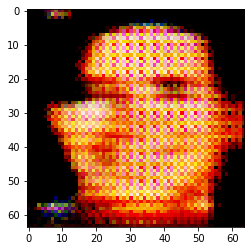

In [259]:
family_no = 56
family_data = generate_image(all_families[family_no][0], all_families[family_no][1], all_families[family_no][2])
inp = [family_data[0],family_data[1]]
inp = tf.cast(inp, tf.float32)
father_inp = inp[0][tf.newaxis,...]
mother_inp = inp[1][tf.newaxis,...]
with tf.device('/gpu:0'):
    gen_output = encoder([father_inp, mother_inp], training=True)
temp = gen_output.numpy()
plt.imshow(np.squeeze(temp))
print(np.amin(temp))
print(np.amax(temp))